In [ ]:
from google.colab import userdata
from google import genai
from abc import ABC, abstractmethod

# Use Gemini for now since it has a free API.
# Ideally we would end up using two models from different labs.
GEMINI_CLIENT = genai.Client(api_key=userdata.get("GOOGLE_API_KEY"))


class Model(ABC):
    @abstractmethod
    def send_message(self, message: str) -> str:
        pass


class Gemini(Model):
    def __init__(self, model: str = "gemini-2.0-flash"):
        self.client = GEMINI_CLIENT
        self._chat = GEMINI_CLIENT.chats.create(model=model)

    def send_message(self, message: str) -> str:
        return self._chat.send_message(message).text

Set up a corporate game of information sharing.

Both agents have internal dialog, and understand the company context, but htey have different levels of familiarity with the issue and make decisions on how much context to share with each other along the way. We plot the progres they each believe is being made after enough turns to reach a belief of "80%"

In [ ]:
import random
import time
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple, Optional, Union


ISSUE_TEMPLATE="""
You are simulating a situation in an organization. To situate the context, consider:
{company_context}

An employee protagonist has been told the following about their character and context:
<employee_profile>
{employee_desc}.
</employee_profile>

Given this context, what you need to simulate now is the issue or request related to {issue_type} that the employee is responsible for addressing (complexity: {issue_complexity}/10).
The employee will need to figure it out after your description, by interfacing with {partner_desc}

Simulate in the second person singular what they should know *at this time* to simulate a {familiarity} understanding of the issue/objective. Begin!
"""

class Company(ABC):
  def __init__(self):
    # Beta distribution for company size to create realistic distribution
    size_modeling = {"min": 10, "max": 10000, "beta_a": 1.4, "beta_b": 3.5}
    self.size = int(np.random.beta(size_modeling["beta_a"], size_modeling["beta_b"]) *
                (size_modeling["max"] - size_modeling["min"]) + size_modeling["min"])

    self.vertical = random.choice(["technology", "healthcare", "finance", "retail", "manufacturing",
                      "education", "government", "media", "energy", "transportation"])
    self.org_model = random.choice(["B2C", "B2B", "B2G", "B2B2C", "marketplace", "platform",
                        "hybrid", "franchise", "consortium", "cooperative"])
    self.process_formality = random.randint(1, 10)
    self.outlook_bullishness = random.uniform(-5, 5)
    self.company_bonus_target = random.uniform(0, 0.25)
    self.issue_complexity = random.randint(1, 10)
    self.issue_type = random.choice(["process_improvement", "incident_response", "customer_escalation",
                        "major_deal", "product_innovation", "regulatory_pressure",
                        "reorganization", "market_expansion", "cost_reduction", "talent_acquisition"])
    self.description = self.describe_company_context()

  def describe_company_context(self) -> str:
    """
    Generate a natural language explanation of the company context
    based on the company parameters.

    Returns:
        str: An English description of the company context
    """
    # Company size and industry description
    if self.size < 50:
        size_desc = f"a small startup with {self.size} employees"
    elif self.size < 200:
        size_desc = f"a growing company with {self.size} employees"
    elif self.size < 1000:
        size_desc = f"a mid-sized company with {self.size} employees"
    elif self.size < 5000:
        size_desc = f"a large enterprise with {self.size} employees"
    else:
        size_desc = f"a major corporation with {self.size} employees"

    # Vertical/industry description
    industry_desc = f"operating in the {self.vertical} industry"

    # Business model description
    model_descriptions = {
        "B2C": "selling directly to consumers",
        "B2B": "providing services to other businesses",
        "B2G": "working primarily with government clients",
        "B2B2C": "selling to businesses who serve consumers",
        "marketplace": "operating a platform connecting buyers and sellers",
        "platform": "providing a technology platform for multiple stakeholders",
        "hybrid": "operating with a mix of business models",
        "franchise": "expanding through franchised locations",
        "consortium": "functioning as a consortium of aligned organizations",
        "cooperative": "structured as a cooperative organization"
    }
    model_desc = model_descriptions.get(self.org_model, f"using a {self.org_model} business model")

    # Process formality
    if self.process_formality <= 3:
        process_desc = "The company culture is highly informal with minimal process and documentation"
    elif self.process_formality <= 5:
        process_desc = "The company has a moderately casual approach to processes and documentation"
    elif self.process_formality <= 7:
        process_desc = "The company follows structured processes with reasonable documentation"
    elif self.process_formality <= 9:
        process_desc = "The company adheres to formal processes with thorough documentation"
    else:
        process_desc = "The company has extremely rigorous processes with comprehensive documentation for everything"

    # Business outlook
    if self.outlook_bullishness < -3:
        outlook_desc = "The business outlook is extremely negative, with major challenges ahead"
    elif self.outlook_bullishness < -1:
        outlook_desc = "The business outlook is concerning, with significant headwinds anticipated"
    elif self.outlook_bullishness < 1:
        outlook_desc = "The business outlook is neutral, with balanced opportunities and challenges"
    elif self.outlook_bullishness < 3:
        outlook_desc = "The business outlook is positive, with good growth opportunities ahead"
    else:
        outlook_desc = "The business outlook is extremely bullish, with exceptional growth expected"

    # Bonus structure
    bonus_desc = f"The company-wide bonus target is {self.company_bonus_target * 100:.1f}% of base salary"

    # Combine everything into a comprehensive context
    context = f"""
Your company is {size_desc}, {industry_desc} and {model_desc}.

{process_desc}. {outlook_desc}. {bonus_desc}.
"""

    return context.strip()

class Player(ABC):
  def __init__(self,
               name: str,
               company: Company,
               role: str | None,
               seniority_level: str | None,
               last_performance_checkin: str | None,
               individual_bonus_pct: float | None,
               personal_context: float | None,
               team_workload: float | None,
               mbti_type: str | None,
               disc_type: str | None,
               issue_familiarity: float | None,
          ):
    """Generate random player parameters based on the defined ranges and options"""
    self.name = name
    self.company = company
    self.role = role if role else random.choice(["product", "engineering", "sales", "support", "legal",
                          "marketing", "finance", "hr", "operations", "executive"])
    self.seniority_level = seniority_level if seniority_level else random.choice(["entry", "mid-level", "senior", "team_lead", "manager",
                            "director", "VP", "SVP", "C_level", "board"])
    self.last_performance_checkin = last_performance_checkin if last_performance_checkin else random.choice(["outstanding", "exceeds_expectations", "meets_expectations",
                                    "inconsistent", "needs_improvement", "new_hire", "post_promotion",
                                    "pre_review", "on_pip", "returning_from_leave"])
    self.individual_bonus_pct = individual_bonus_pct if individual_bonus_pct else random.uniform(0, 0.25)
    self.personal_context = personal_context if personal_context else random.uniform(-5, 5)
    self.team_workload = team_workload if team_workload else random.uniform(0.7, 1.5)

    # Generate MBTI type
    self.mbti_type = mbti_type if mbti_type else (
        random.choice(["E", "I"]) +
        random.choice(["S", "N"]) +
        random.choice(["T", "F"]) +
        random.choice(["J", "P"])
    )

    # Select primary DISC type
    self.disc_type = random.choice(["D", "I", "S", "C"])

    # Generate issue familiarity
    self.issue_familiarity = random.uniform(0.01, 1)

    self.full_description = self.long_player_context()
    self.public_description = self.short_profile()
    self.agent = Gemini() # send_message maintains state.

  def send_message(self, message: str) -> str:
    p = self.agent.send_message(message)
    print(self.name, message)
    print(self.name, p)
    time.sleep(4)
    return p.strip()

  def long_player_context(self) -> str:
    """
    Generate a natural language explanation of the player's context
    based on their parameters.

    Returns:
        str: An English description of the player's context
    """
    # Role and seniority description
    role_description = f"You are a {self.seniority_level} level {self.role} professional working in this organization: {self.company.description}"

    # Performance context
    if self.last_performance_checkin == "outstanding":
        performance_desc = "Your last performance review was outstanding, placing you among the top performers"
    elif self.last_performance_checkin == "exceeds_expectations":
        performance_desc = "Your last performance review noted that you exceed expectations in your role"
    elif self.last_performance_checkin == "meets_expectations":
        performance_desc = "Your last performance review indicated that you meet all expectations for your position"
    elif self.last_performance_checkin == "inconsistent":
        performance_desc = "Your last performance review noted some inconsistency in your work quality"
    elif self.last_performance_checkin == "needs_improvement":
        performance_desc = "Your last performance review suggested several areas where improvement is needed"
    elif self.last_performance_checkin == "new_hire":
        performance_desc = "You're a new hire and haven't had a formal performance review yet"
    elif self.last_performance_checkin == "post_promotion":
        performance_desc = "You were recently promoted and are still adapting to your new responsibilities"
    elif self.last_performance_checkin == "pre_review":
        performance_desc = "Your annual performance review is coming up soon"
    elif self.last_performance_checkin == "on_pip":
        performance_desc = "You're currently on a performance improvement plan"
    elif self.last_performance_checkin == "returning_from_leave":
        performance_desc = "You've recently returned from extended leave"

    # Bonus target
    bonus_desc = f"Your individual bonus target is {self.individual_bonus_pct * 100:.1f}% of your base salary"

    # Team workload
    if self.team_workload < 0.85:
        workload_desc = "Your team is currently operating with a comfortable workload"
    elif self.team_workload < 1.0:
        workload_desc = "Your team has a moderate workload, with occasional busy periods"
    elif self.team_workload < 1.2:
        workload_desc = "Your team is quite busy, with a heavy but manageable workload"
    else:
        workload_desc = "Your team is extremely overloaded and working at an unsustainable pace"

    # Personal context
    if self.personal_context < -3:
        personal_desc = "Your personal life is extremely challenging right now, creating significant distractions at work"
    elif self.personal_context < -1:
        personal_desc = "You're dealing with some personal difficulties that occasionally affect your work focus"
    elif self.personal_context < 1:
        personal_desc = "Your personal life is relatively stable, neither helping nor hindering your work"
    elif self.personal_context < 3:
        personal_desc = "Your personal life is going well, giving you additional energy for work"
    else:
        personal_desc = "Your personal life is exceptionally positive, providing you with abundant energy and focus"

    # MBTI description
    mbti_descriptions = {
        'E': "extroverted",
        'I': "introverted",
        'S': "detail-oriented",
        'N': "big-picture focused",
        'T': "logical and analytical",
        'F': "empathetic and values-driven",
        'J': "structured and organized",
        'P': "flexible and adaptable"
    }

    mbti_traits = [mbti_descriptions[letter] for letter in self.mbti_type]
    mbti_desc = f"You tend to be {mbti_traits[0]}, {mbti_traits[1]}, {mbti_traits[2]}, and {mbti_traits[3]}"

    # DISC description
    disc_descriptions = {
        'D': "You're direct, decisive, and focused on results and the bottom line",
        'I': "You're influential, enthusiastic, and naturally good at building relationships",
        'S': "You're steady, patient, and value harmony and cooperation",
        'C': "You're conscientious, analytical, and focused on quality and accuracy"
    }
    disc_desc = disc_descriptions[self.disc_type]

    # Issue familiarity
    if self.issue_familiarity < 0.2:
        familiarity_desc = "You have very little familiarity with the current issue"
    elif self.issue_familiarity < 0.4:
        familiarity_desc = "You have basic knowledge about the current issue"
    elif self.issue_familiarity < 0.6:
        familiarity_desc = "You have moderate familiarity with the current issue"
    elif self.issue_familiarity < 0.8:
        familiarity_desc = "You have strong knowledge about the current issue"
    else:
        familiarity_desc = "You're an expert on the current issue"

    # Combine everything into a comprehensive context
    context = f"""
{role_description}. {performance_desc}.

{bonus_desc}. {workload_desc}. {personal_desc}.

Personality traits: {mbti_desc}. {disc_desc}.

Regarding the current situation: {familiarity_desc}.
"""

    return context.strip()

  def short_profile(self) -> str:
    return Gemini().send_message("""
      In 30 words, what would the person below be known for in their organization? Write in a professional 3rd person voice.
      """ + self.long_player_context())

  def observe_orient_decide_progress(self, message: str, time: str, coworker_name: str) -> float:
    OOD_TEMPLATE = """
    Reply from {coworker_name} after {time}: {reply}.
    First you are observing and reflecting on this reply - what is your internal dialog or what do you look into and find independently?
    Start every line with "(internal)".
    """
    print(self.agent.send_message(OOD_TEMPLATE.format(reply=message, time=time, coworker_name=coworker_name)))
    progress = self.agent.send_message("How much progress do you think this amounts to on the current issue as a percentage (0-100)? Write only the number, no symbol")
    return float(progress)/100

  def act(self) -> str:
    ACT_TEMPLATE = """
    Having observed and reflected above, how long did this take you? And considering your full context, what would you like to write to {partner}?
    You must write only in this format:
    Me [response_time]:lorem ipsum
    (with a number and 1-letter unit in the brackets, eg [1m])
    """
    response = self.agent.send_message(ACT_TEMPLATE)
    print(response)
    return response


class CorporateGameTheory(ABC):
    """Main game class for corporate scenario simulations"""

    def __init__(self):
      self.company = Company()
      self.player_a = Player("Erin", self.company)
      self.player_b = Player("Sam", self.company)
      self.last_turn = ""
      self.last_reply = ""
      self.issue_description = Gemini().send_message(ISSUE_TEMPLATE.format(
        employee_desc=self.player_a.full_description,
        company_context=self.company.description,
        issue_complexity=self.company.issue_complexity,
        issue_type=self.company.issue_type,
        partner_desc=self.player_b.public_description,
        familiarity=self.player_a.issue_familiarity))
      self.steps=0
      self.context_levels_a=[]
      self.context_levels_b=[]
      self.progress_a=[]
      self.progress_b=[]

    def step(self):
      self.steps+=1
      FIRST_TURN="""
      {player_context}

      {issue}:

      Your options today will primarily be based on partnering with {partner} to address the situation as fully as you can, considering your context.
      About {partner}: {partner_desc}
      First you are observing and reflecting on this situation: what is your internal dialog or what do you look into and find independently?
      Start every line with "(internal)". Begin!
      """

      SECOND_TURN="""
      {player_context}

      {partner} has sent you this message:
      {message}
      What you know about {partner} is this: {partner_desc}
      Now you are observing and reflecting on this situation: what is your internal dialog or what do you look into and find independently?
      Start every line with "(internal)". Begin!
      """
      if self.last_turn == "":
        self.player_a.send_message(FIRST_TURN.format(
            player_context=self.player_a.full_description,
            issue=self.issue_description,
            partner=self.player_b.name,
            partner_desc=self.player_b.public_description
          ))
        self.context_levels_a.append(int(self.player_a.send_message(f"NOW: How much context will you need to share with {self.player_b.name}? reply with a single digit between 0-9")[-1]))
        self.last_reply = self.player_a.act()
        self.player_b.send_message(SECOND_TURN.format(
            player_context=self.player_b.full_description,
            partner=self.player_a.name,
            partner_desc=self.player_a.public_description,
            message=self.last_reply
          ))
        self.context_levels_b.append(int(self.player_b.send_message(f"NOW: How much context should you include in your reply to {self.player_a.name}? reply with a single digit between 0-9")[-1]))
        self.last_reply = self.player_b.act()
        self.last_turn = "b"
      elif self.last_turn == "a":
        self.progress_b.append(self.player_b.observe_orient_decide_progress(self.last_reply, "now", self.player_a.name))
        self.context_levels_b.append(int(self.player_b.send_message(f"NOW: How much context should you add in your reply to {self.player_a.name}? on a scale from 0-9, where 4 is average, lower numbers are terse, higher numbers are increasingly detailed? Write your decision with only a single digit.")))
        self.last_reply = self.player_b.act()
        self.last_turn = "b"
      elif self.last_turn == "b":
        self.progress_a.append(self.player_a.observe_orient_decide_progress(self.last_reply, "now", self.player_b.name))
        self.context_levels_a.append(int(self.player_a.send_message(f"NOW: How much context will you need to add in your reply to {self.player_b.name}? reply with a single digit between 0-9")))
        self.last_reply = self.player_a.act()
        self.last_turn = "a"

In [ ]:
game = CorporateGameTheory()
print(game.company.description)
print()
print(game.issue_description)

Your company is a large enterprise with 1283 employees, operating in the media industry and selling to businesses who serve consumers.

The company has extremely rigorous processes with comprehensive documentation for everything. The business outlook is extremely bullish, with exceptional growth expected. The company-wide bonus target is 20.4% of base salary.

Okay, here's what you know, or should know right now, regarding the market expansion issue:

The company is aggressively pursuing market expansion into three new, strategically identified regions: Southeast Asia, Latin America, and the Middle East. Your team is being tasked with handling the HR component of this expansion. This includes:

1.  **Talent Acquisition:** You need to develop a robust recruitment strategy to attract and onboard talent in each of these regions. This isn't just about finding people; it's about finding the *right* people who understand the local markets, have the necessary skills, and align with our compan

In [ ]:
for i in range(12):
  game.step()
  time.sleep(7)
  if game.steps>2 and (game.progress_b[-1]>0.8 or game.progress_a[-1]>0.8):
    break;

Erin 
      You are a C_level level hr professional working in this organization: Your company is a large enterprise with 1283 employees, operating in the media industry and selling to businesses who serve consumers.

The company has extremely rigorous processes with comprehensive documentation for everything. The business outlook is extremely bullish, with exceptional growth expected. The company-wide bonus target is 20.4% of base salary.. You were recently promoted and are still adapting to your new responsibilities.

Your individual bonus target is 10.8% of your base salary. Your team is extremely overloaded and working at an unsustainable pace. Your personal life is extremely challenging right now, creating significant distractions at work.

Personality traits: You tend to be extroverted, big-picture focused, logical and analytical, and flexible and adaptable. You're direct, decisive, and focused on results and the bottom line.

Regarding the current situation: You have moderate fa

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '54s'}]}}

In [ ]:
game.progress_a

[0.3, 0.55, 0.7, 0.75]

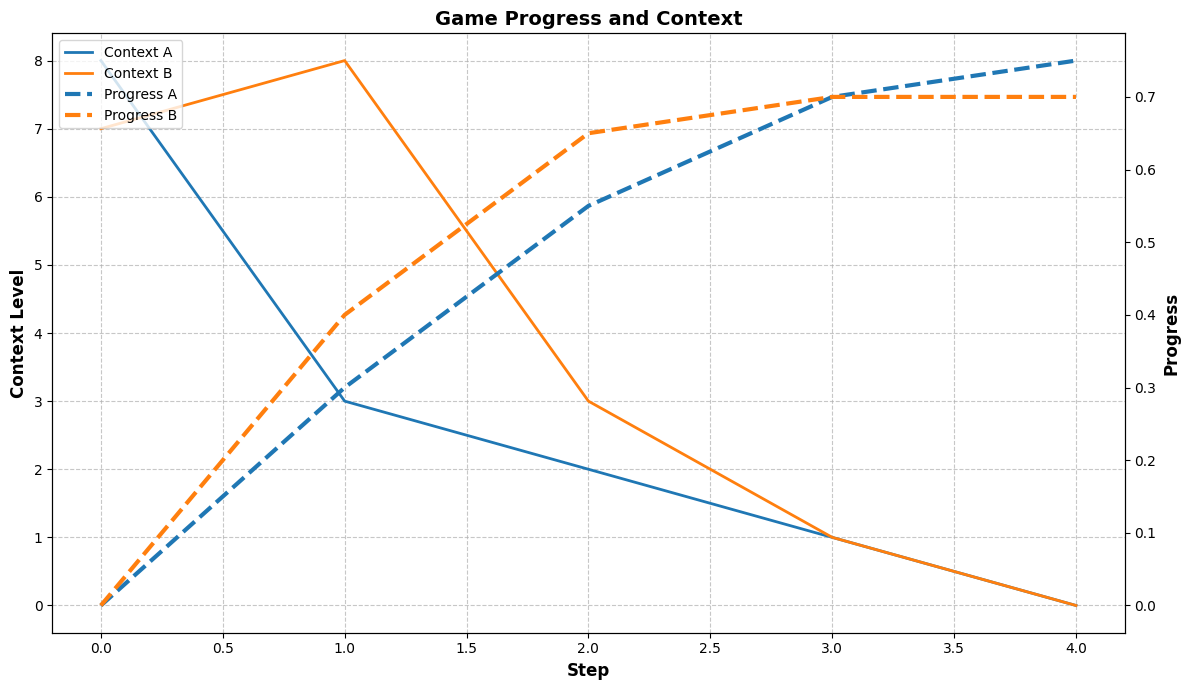

In [ ]:
# Create figure and primary axis
fig, ax1 = plt.figure(figsize=(12, 7)), plt.gca()

# Plot context series on the primary y-axis
context_a_line, = ax1.plot(range(len(game.context_levels_a)), game.context_levels_a,
                          color='#1f77b4', linewidth=2, label='Context A')
context_b_line, = ax1.plot(range(len(game.context_levels_b)), game.context_levels_b,
                          color='#ff7f0e', linewidth=2, label='Context B')

ax1.set_xlabel('Step', fontsize=12, fontweight='bold')
ax1.set_ylabel('Context Level', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot progress series on the secondary y-axis with matching colors and dashed lines
progress_a_line, = ax2.plot(range(len([0] + list(game.progress_a))), [0] + list(game.progress_a),
                           color='#1f77b4', linewidth=3, linestyle='--', label='Progress A')
progress_b_line, = ax2.plot(range(len([0] + list(game.progress_b))), [0] + list(game.progress_b),
                           color='#ff7f0e', linewidth=3, linestyle='--', label='Progress B')

ax2.set_ylabel('Progress', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines = [context_a_line, context_b_line, progress_a_line, progress_b_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.title('Game Progress and Context', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()